# Outline

- Background to Project
- Code Imports
- Import Data
- Models
    - (Models = KNN, LR, RF, AdaBoost, Gradient, XG Boost, NN-tanh, NN-Relu)
        - Build Pipeline
        - GridSearch
            - Parameter Grid
            - Construct GridSearch
            - Fit GridSearch
            - Output Best Accuracy
            - Save Model's Best Accuracy to Summary Table
        - (From RF take feature importance)
        - (Gradient = XG Boost?)
- Evaluate Best model
    - Confusion Matrix for best model
- Function to predict next fight
- Conclusion
    - Future Work
    

# Code Imports

## Library Installations

In [1]:
# !conda install py-xgboost

## Import Libraries

In [2]:
# For Dataframes and arrays
import numpy as np
import pandas as pd
# Visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Preprocessing Data
    # Train:Test split
from sklearn.model_selection import train_test_split
    # Scaling
from sklearn.preprocessing import StandardScaler
    # Feature Extraction
from sklearn.decomposition import PCA

# Modeling
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from xgboost import XGBClassifier
    # Prevent Kernel Dying
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Neural Network
import tensorflow as tf
import keras
from keras.layers import Dense, Dropout, Activation, LeakyReLU
from keras.models import Sequential
from keras.optimizers import SGD

# Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

# Warnings
# import warnings
# warnings.filterwarnings("ignore")

# Set random seeds
np.random.seed(123)
tf.set_random_seed(123)

Using TensorFlow backend.


## Local Code Imports - Do not delete

In [3]:
# DO NOT REMOVE THESE
%load_ext autoreload
%autoreload 2

In [4]:
# DO NOT REMOVE This
%reload_ext autoreload

In [5]:
## DO NOT REMOVE
## import local src module -
## src in this project will contain all your local code
## clean_data.py, model.py, visualize.py, custom.py
from src import make_data as mk
from src import visualize as viz
from src import model as mdl
from src import pandas_operators as po
from src import custom as cm

def test_src():
    mk.test_make_data()
    viz.test_viz()
    mdl.test_model()
    po.test_pandas()
    
    return 1

In [6]:
test_src()

In make_data
In Visualize
In Model
In pandas ops


1

# Project Background

## UFC Background

In [7]:
# Credit to National Geographic
cm.ufc_intro_vid()

## Project Objective

### Compare a Variety of Machine Learning Models
For this project we are classifying. There are many choices of classification algorithm, each with its own strengths and weaknesses. There is no single classifier that always works best across all scenarios so we will compare a handful of different learning algorithms to select the best model for our particular problem.

### Assumptions made
- In reality, each bout has 4 possible outcomes; fighter 1 wins, fighter 2 wins, draw or no contest.  For simplicity of modeling, these outcomes have been reduced to simply fighter 1 wins or fighter 2 wins.  
- The models are trained on fighter statistics that reflect their current statistics, not those at the time of the fight.  i.e. a fighter's first bout will feature their statistics the same statistics as their latest bout.

# Import Data

In [214]:
data = pd.read_csv('../data/processed/combined')
data.head()

,date,fighter1,fighter2,winner_is_fighter1,title_fight,fighter1_win,fighter1_lose,fighter1_total_bouts,fighter1_win_rate,fighter1_height_inches,...,fighter2_slpm,fighter2_str_acc,fighter2_sapm,fighter2_str_def,fighter2_td_avg,fighter2_td_acc,fighter2_td_def,fighter2_sub_avg,fighter1_age_at_fight,fighter2_age_at_fight
0,2018-11-17,Santiago Ponzinibbio,Neil Magny,1,0,28,3,31,0.90,72.0,...,3.86,46,2.22,56,2.62,46,60,0.3,32.0,31.0
1,2018-11-17,Darren Elkins,Ricardo Lamas,0,0,25,7,32,0.78,70.0,...,2.87,45,2.61,59,1.66,32,47,1.0,34.0,36.0
2,2018-11-17,Johnny Walker,Khalil Rountree Jr.,1,0,15,3,18,0.83,77.0,...,2.30,34,3.29,38,0.00,0,50,0.3,26.0,28.0
3,2018-11-17,Cezar Ferreira,Ian Heinisch,0,0,14,7,21,0.67,73.0,...,3.49,58,1.67,52,0.81,14,50,1.6,33.0,30.0
4,2018-11-17,Guido Cannetti,Marlon Vera,0,0,8,5,13,0.62,66.0,...,3.23,44,3.93,52,0.78,37,68,1.3,38.0,25.0


## Train-Test Split

In [9]:
X = data.drop(['date', 'fighter1', 'fighter2', 'winner_is_fighter1'],axis=1)
y = data['winner_is_fighter1']

- We no longer require the fighter names

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

print('X_Train: \n\tObservations: {} \tFeatures: {} \t{}% of data'.format(X_train.shape[0], X_train.shape[1], len(X_train)/len(X)*100))
print('X_Test: \n\tObservations: {} \tFeatures: {} \t{}% of data'.format(X_test.shape[0], X_test.shape[1], len(X_test)/len(X)*100))

X_Train: 
	Observations: 3199 	Features: 45 	70.0% of data
X_Test: 
	Observations: 1371 	Features: 45 	30.0% of data


- We set the random state so that our results can be reproduced easily
- The stratify argument ensures that we maintain the proportion of class labels, i.e. the same proportion of fighter 1 wins to fighter 2 wins, across the original data, y_train and y_test.

In [11]:
X_train = X_train.astype(float)
X_test = X_test.astype(float)

- Many of the features are type integer.  Several of the models we will run prefer to have type float as an input

## Scaling

- Many of the machine learning and optimization algorithms that we will be using require feature scaling in order to optimize performance. 
- We will standardize the features using StandardScaler from scikit-learn's preprocessing module.
    - This will transform the data, resulting in each feature having a mean of 0 and a standard deviation of 1.

In [12]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

- We will use the same scaling parameters to standardize the test set, so that the values in the training and test dataset are comparable to each other.

# Models

**Compare Several Models**

- For this project we are classifying bouts.  There are many choices of classification algorithm, each with its own strengths and weaknesses.  
- There is no single classifier that always works best across all scenarios so we will compare a handful of different learning algorithms to select the best model for our particular problem.  

**Cross Validation**

- Train-test splitting does not ensure a 'random' split, which may result in our models overfitting our data.  We can use *cross-validation* to mitigate this issue.
- There are several varieties of cross validation available in [SK Learn's Model Selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection)
- We will be using K-Fold Cross Validation, with a K of 5 
    - We use each fold as a validation set, with the remaining folds used to train our model
    - The computational cost will increase with each increase in the number of folds.
        - Our dataset is relatively small so this should not be a big problem.

**Track each model's statistics**
- We will keep track of each models statistics and performance in a dataframe

In [13]:
models_summary = pd.DataFrame()
models_summary.rename_axis('Model', axis='columns', inplace=True)

**Accuracy is our best metric**
- Although there are many metrics to evaluate our models against one another, the *Occam's Razor* principle can often be applied (That is, that the simpler explanation is to be preferred). In the case of comparing our models, we are most interested in how many fights we correctly predict, i.e. the accuracy. There is virtually no class imbalance and the cost associated with a false positive and a false negative are identical.

## Baseline Model

- Our Base Rate will be to classify every bout as the largest class
- Our Null Rate will be the accuracy of trivially predicting the most-frequent class

In [14]:
baseline_accuracy = cm.model_baseline(y_train)

# Save the Baseline Model to our models summary dataframe
models_summary['Baseline'] = [baseline_accuracy]  

Fighter 1 wins: 1608
Fighter 2 wins: 1591

Our Baseline Model will always predict Fighter 1 wins
Null Rate: 50.27%


In [15]:
models_summary.rename({0: 'Accuracy'}, inplace=True)
models_summary

Model,Baseline
Accuracy,0.502657


## K-Nearest Neighbors

**Why Use KNN?**
- K-Nearest Neighbors (KNN) is a instance-based learning type of nonparamteric model. It memorizes the training dataset and adapts immediately as we collect new training data.
- The computational complexity for classifying new samples grows linearly with the number of samples in the training dataset. i.e. with every bout that occurs, and updates the model, the model becomes slower and slower to run. Our dataset is relatively very small so we are able to use this model
- We are using the default Minkowski distance, which requires our distances to be standardized.

**Dimensionality Reduction using PCA**
- Principle Component Analysis (PCA) is a form of feature extraction, where we transform the data onto a new feature space whilst maintaining most of the relevant information.
- Main benefits of PCA:
    - Improves computational efficiency of our learning algorithm
    - Reduces the "curse of dimensionality", which can improve the predictive performance

The top 30 principal components explains 94.7% of the variance


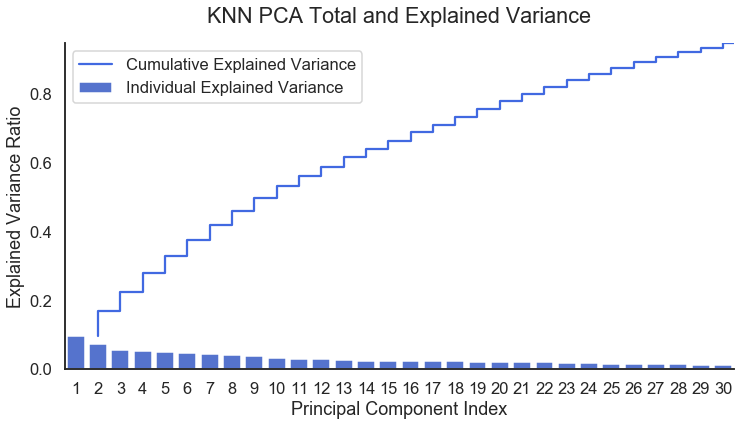

In [16]:
cm.plot_explained_variance(X_train_std, features_to_show=30, title='KNN PCA Total and Explained Variance')

**Choosing the right number of neighbors (k)**
- This is critical to avoid over and underfitting our model.
- We can do this manually by plotting the accuracy of the KNN model, as we change the k value.  
- Our classification is binary, so we should choose k to be an odd number to avoid tied votes.

Highest Accuracy is 68.34%, when K is 25


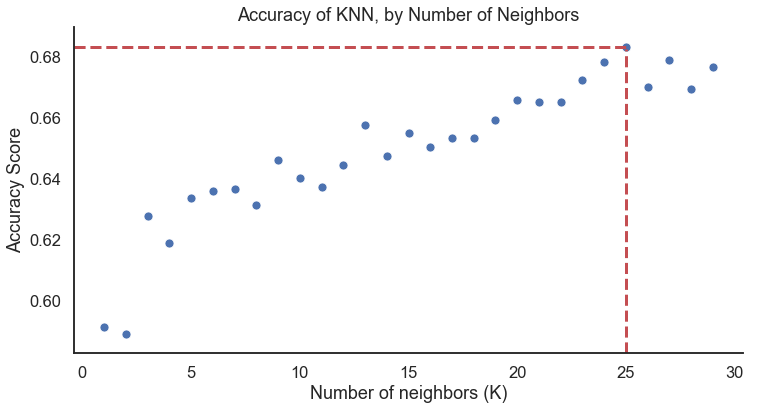

In [17]:
cm.acc_by_k_value(X_train_std, y_train, X_test_std, y_test)

- The best K is the one that results in the highest test accuracy score. 
    - The problem with using the chart above is that we are inadvertently using our test set as a training set. We are forcing the model to fit the test set, and causing the model to overfit.
- A better approach is to use **k-fold cross validation**.
    - This will allow us to compare hyperparameters (such as number of neighbors) on a validation set, and then only use the test data to represent how well the model performs on unseen data

In [18]:
# cm.model_knn_grid(X_train, y_train)

In [19]:
knn_accuracy = cm.model_knn(X_train_std, y_train, X_test_std, y_test, n_neighbors=21)

# Add KNN results to models summary dataframe
models_summary['KNN'] = [knn_accuracy]

Accuracy for K-Nearest Neighbors model (k = 21): 66.5%


In [20]:
models_summary

Model,Baseline,KNN
Accuracy,0.502657,0.665208


## Logistic Regression

In [21]:
# cm.model_logreg_grid(X_train_std, y_train)

In [22]:
lr_accuracy = cm.model_logreg(C_=0.1, X_train_=X_train_std, y_train_=y_train, X_test_=X_test_std, y_test_=y_test)

Accuracy for Logistic Regression model: 69.7%


In [23]:
# Add Logistic Regression results to models summary dataframe
models_summary['Logistic Regression'] = lr_accuracy

In [24]:
models_summary

Model,Baseline,KNN,Logistic Regression
Accuracy,0.502657,0.665208,0.697301


## Random Forest

- Because this is an ensemble algorithm, the model is naturally resistant to noise and variance in the data (which helps reduce overfitting), and generally tends to perform quite well.
- As it is an ensemble alogorithm we have the computational cost of training each model

In [25]:
X_train_top_features = X_train.copy()
X_train_top_features = cm.rename_top_features(X_train_top_features)

In [26]:
# cm.model_rf_grid(X_train, y_train)

In [27]:
rf_accuracy = cm.model_random_forest(X_train_top_features, y_train, X_test, y_test, 
                   max_depth_=4, min_samples_leaf_=0.05, 
                   min_samples_split_=0.05, n_estimators_=110)

# Add Random Forest results to models summary dataframe
models_summary['Random Forest'] = rf_accuracy 

Accuracy for Random Forest model : 69.2%


In [28]:
models_summary

Model,Baseline,KNN,Logistic Regression,Random Forest
Accuracy,0.502657,0.665208,0.697301,0.692195


## AdaBoost

In [29]:
# cm.model_ada_boost_grid(X_train, y_train)

In [30]:
ada_accuracy = cm.model_ada_boost(X_train, y_train, X_test, y_test,
                                  learning_rate=0.5, n_estimators=70)

Accuracy for Ada Boost model : 71.3%


In [31]:
# Add Ada Boost results to models summary dataframe
models_summary['Ada Boost'] = ada_accuracy

In [32]:
models_summary

Model,Baseline,KNN,Logistic Regression,Random Forest,Ada Boost
Accuracy,0.502657,0.665208,0.697301,0.692195,0.712619


## Gradient Boosting (XG Boost)

- eXtreme Gradient Boosting (XG Boost) is a form of gradient boosting which often produces the best performances, amongst gradient boosting algorithms
- XG Boost is able to parallelize the construction of decision trees across all our computer's CPU cores during the training phase
    - This can even be done across a cluster of computers 

In [57]:
xgb_accuracy = cm.model_xgboost(X_train, y_train, X_test, y_test)[0]
models_summary['XG Boost'] = xgb_accuracy

Accuracy for XGBoost model : 75.5%


In [58]:
models_summary

,Accuracy,XG Boost
Model,,
Baseline,0.502657,0.754923
KNN,0.665208,0.754923
Random Forest,0.692195,0.754923
Neural Network (tanh),0.693654,0.754923
Logistic Regression,0.697301,0.754923
Neural Network (relu),0.700948,0.754923
Ada Boost,0.712619,0.754923
XG Boost,0.754923,0.754923


## Neural Network (tanh)

In [35]:
model_tanh = cm.model_compile_neural_network(X_train_std, 'tanh')

In [36]:
history_tanh = cm.model_fit_neural_network(X_train_std, y_train, model_tanh, 100)

We have reduced the loss by 28.92% by training the model through 100 epochs


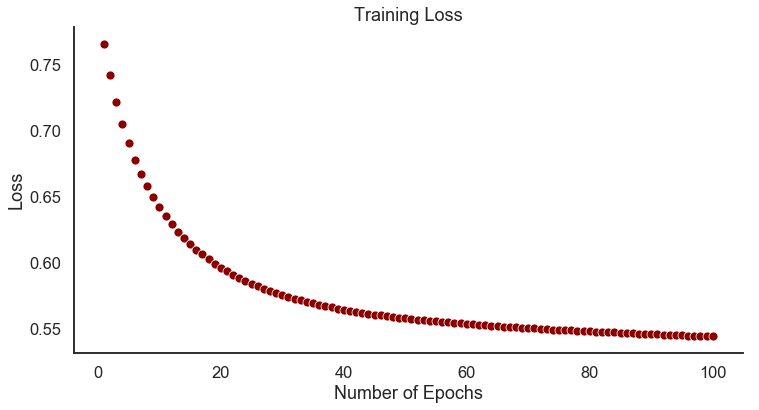

In [37]:
loss = history_tanh.history['loss']
cm.plot_training_loss(loss)

We have increased the accuracy by 58.97% by training the model through 100 epochs


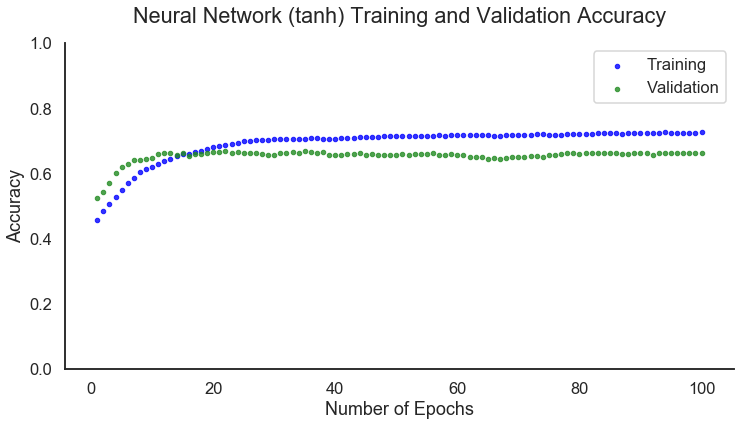

In [38]:
acc = history_tanh.history['acc']
val_acc = history_tanh.history['val_acc']

cm.plot_training_and_validation_accuracy(acc, val_acc, history_tanh,
                                      title='Neural Network (tanh) Training and Validation Accuracy')

/Users/adam/Documents/flatiron/ml_ufc_data/src/custom.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['val_acc_avg'][mov_avg_n-1:] = list(val_acc_avg)


We have increased the accuracy by 58.97% by training the model through 100 epochs


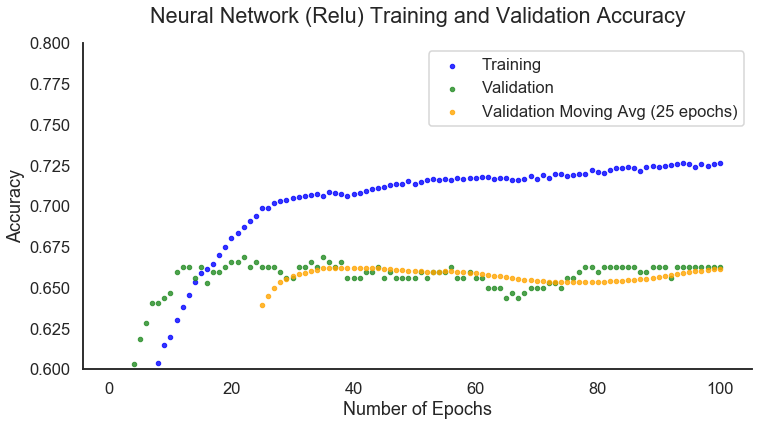

In [39]:
cm.plot_training_and_validation_accuracy(acc, val_acc, history_tanh,
                                      title='Neural Network (Relu) Training and Validation Accuracy',
                                      y_lim=(0.6,0.8), show_mov_avg=True)

In [40]:
nn_tanh_accuracy = cm.model_test_acc_neural_network(X_test_std, y_test, model_tanh)

# Add Score to Models Summary DataFrame
models_summary['Neural Network (tanh)'] = nn_tanh_accuracy

Test Accuracy: 69.0%


In [41]:
models_summary

Model,Baseline,KNN,Logistic Regression,Random Forest,Ada Boost,XG Boost,Neural Network (tanh)
Accuracy,0.502657,0.665208,0.697301,0.692195,0.712619,0.754923,0.693654


## Neural Network (Relu)

In [42]:
model_relu = cm.model_compile_neural_network(X_train_std, 'relu')

In [43]:
history_relu = cm.model_fit_neural_network(X_train_std, y_train, model_relu, 100)

We have reduced the loss by 25.03% by training the model through 100 epochs


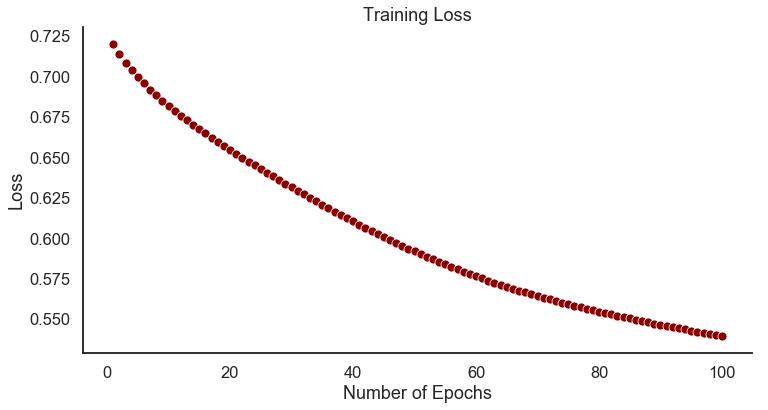

In [44]:
loss = history_relu.history['loss']
cm.plot_training_loss(loss)

We have increased the accuracy by 49.5% by training the model through 100 epochs


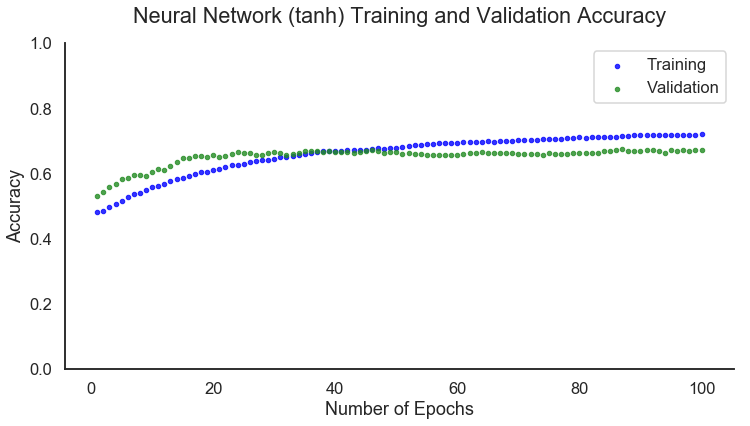

In [45]:
acc = history_relu.history['acc']
val_acc = history_relu.history['val_acc']

cm.plot_training_and_validation_accuracy(acc, val_acc, history_relu,
                                      title='Neural Network (tanh) Training and Validation Accuracy')

In [46]:
nn_relu_accuracy = cm.model_test_acc_neural_network(X_test_std, y_test, model_relu)

# Add Score to Models Summary DataFrame
models_summary['Neural Network (relu)'] = nn_relu_accuracy

Test Accuracy: 70.0%


In [47]:
models_summary

Model,Baseline,KNN,Logistic Regression,Random Forest,Ada Boost,XG Boost,Neural Network (tanh),Neural Network (relu)
Accuracy,0.502657,0.665208,0.697301,0.692195,0.712619,0.754923,0.693654,0.700948


# Evaluation of Models

In [48]:
models_summary = models_summary.T

# Sort models_summary into order
models_summary.sort_values('Accuracy', inplace=True)

models_summary

,Accuracy
Model,
Baseline,0.502657
KNN,0.665208
Random Forest,0.692195
Neural Network (tanh),0.693654
Logistic Regression,0.697301
Neural Network (relu),0.700948
Ada Boost,0.712619
XG Boost,0.754923


## Barchart to compare Models

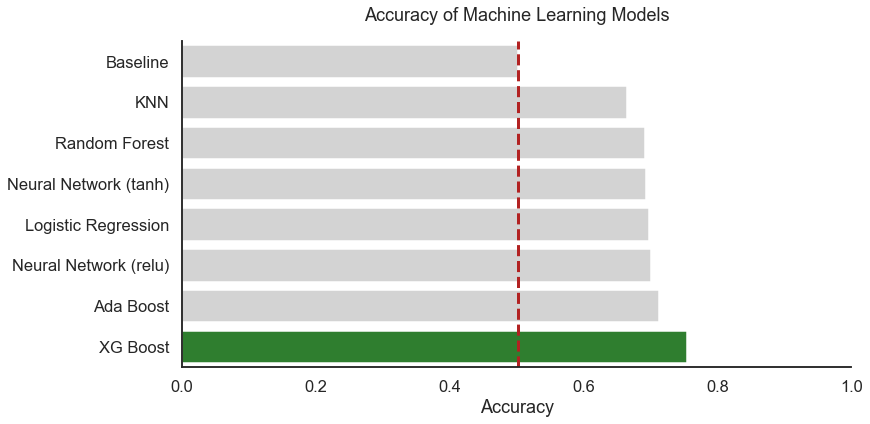

In [256]:
cm.plot_compare_models(models_summary, 'Accuracy')

## Confusion Matrix of Best Model

Accuracy for XGBoost model : 75.5%
Accuracy for XGBoost model : 75.5%
Normalized confusion matrix



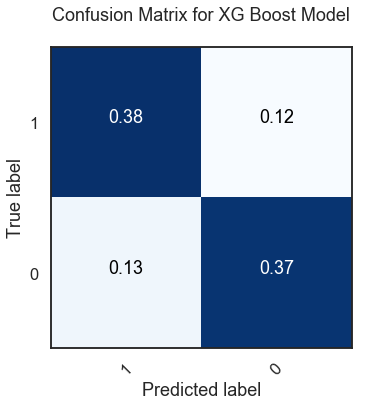

In [53]:
# XG Boost
y_test = cm.model_xgboost(X_train, y_train, X_test, y_test)[2]
y_test_pred = cm.model_xgboost(X_train, y_train, X_test, y_test)[3]

conf_matrix = confusion_matrix(y_test,y_test_pred)
cm.plot_confusion_matrix(cm=conf_matrix, classes=[1,0], normalize=True, title='Confusion Matrix for XG Boost Model');

# Function to Predict a Fight

**plan**
- ask for 2 fighter names
    - if it is a title fight
- gather the statistics for each fighter
    - fighter1: grab appropriate stats from fighters table
        - same for fighter2
    - Make a dataframe for title_fight, f1_stats, f2_stats
- run dataframe through the clf_xg.predict(df) and clf_xg.predict_proba(df)
- another dataframe to have f1_name, f2_name, outcome, probability

### fighter names, title fight and date of fight

In [95]:
def ask_fighter_names():
    '''Ask the user for the name of each fighter'''
    fighter1_name = input('What is the name of Fighter 1?')
    fighter2_name = input('What is the name of Fighter 2?')
    return {'f1_name': fighter1_name, 'f2_name': fighter2_name}

In [99]:
# Test
names = ask_fighter_names()
names['f1_name']

What is the name of Fighter 1?jack
What is the name of Fighter 2?jill


'jack'

In [112]:
def ask_title_fight():
    '''Ask the user whether the fight isa title fight'''
    title_fight_q = input('Is this a title fight? (yes/no)')
    if title_fight_q=='yes':
        title_fight = 1
    elif title_fight_q=='no':
        title_fight = 0
    return title_fight

In [113]:
# Test
title_fight = ask_title_fight()
title_fight

Is this a title fight? (yes/no)yes


1

In [165]:
from datetime import datetime

In [168]:
def ask_date_of_fight():
    '''Ask the user when the fight takes place'''
    fight_date = input('When will the fight take place? (YYYY-MM-DD)')
    datetime.strptime(fight_date, '%Y-%m-%d')
    
    return fight_date

In [169]:
# Test
ask_date_of_fight()

When will the fight take place? (YYYY-MM-DD)2019-09-15


'2019-09-15'

### Gather Stats for each fighter

In [231]:
def assemble_fighter_stats(fighter_name):
    '''Gathers the statistics for the fighter, based off of their name'''
    
    fighter_stats = fighters[fighters['name']==fighter_name].iloc[:,3:]
    
    return fighter_stats

In [111]:
# Test
fighter_name = 'Max Holloway'
fighter_stats = assemble_fighter_stats(fighter_name)
fighter_stats

,win,lose,draw,total_bouts,win_rate,height_inches,reach,stance_open_stance,stance_orthodox,stance_sideways,stance_southpaw,stance_switch,slpm,str_acc,sapm,str_def,td_avg,td_acc,td_def,sub_avg
835,19,3,0,22,0.86,71.0,69.0,0,1,0,0,0,6.2,43,3.9,65,0.28,80,83,0.5


### Calculate Age at fight

In [221]:
def fighter_dob(name, fighter_df):
    '''returns the fighter date of birth from a fighter dataframe'''
    
    return fighter_df[fighter_df['name']==name]['dob']

In [222]:
# Test
fighter_name = 'Max Holloway'
f1_dob = fighter_dob(fighter_name, fighters)
f1_dob

835    1991-12-04
Name: dob, dtype: object

In [ ]:
def col_to_datetime(col, data):
    '''convert a column to datetime format'''
    
    return pd.to_datetime(data[col], format='%Y-%m-%d', errors='coerce')

In [263]:
def input_age_at_fight(prediction_stats, names):
    '''Takes in a fighters date of birth, calculates their age vs a date and drops unwanted columns'''
    
    # Fighter dobs
    prediction_df['fighter1_dob'] = fighter_dob(names['f1_name'], prediction_df)
    prediction_df['fighter2_dob'] = fighter_dob(names['f2_name'], prediction_df)

    # Convert dates to datetime format
    date_cols = ['date', 'fighter1_dob', 'fighter2_dob']
    for col in date_cols:
        prediction_df[col] = col_to_datetime(col, prediction_df)

    # Calculate and input age at fight
    cm.calc_age_at_fight(prediction_df, 'fighter1_age_at_fight', 'fighter1_dob')
    cm.calc_age_at_fight(prediction_df, 'fighter2_age_at_fight', 'fighter2_dob')

    # Drop unwanted columns
    cols_to_drop = ['date', 'fighter1_dob', 'fighter2_dob']
    prediction_df.drop(labels=cols_to_drop, axis=1, inplace=True)

    return prediction_stats
    

### New DF with same columns as first DF

In [216]:
def create_blank_test_df(data, unwanted_columns={'fighter1', 'fighter2', 'winner_is_fighter1'} ):    
    '''Creates a blank dataframe which copies the columns from an input dataframe'''
    # Copy the columns from data table
    prediction_cols = list(data.columns)
    # Remove unwanted columns
    prediction_cols = [e for e in prediction_cols if e not in unwanted_columns]
    # Create Blank Dataframe from columns
    prediction_df = pd.DataFrame(columns=prediction_cols)

    return prediction_df

In [217]:
# Test
df = create_blank_test_df(data)
df

,date,title_fight,fighter1_win,fighter1_lose,fighter1_total_bouts,fighter1_win_rate,fighter1_height_inches,fighter1_reach,fighter1_stance_open_stance,fighter1_stance_orthodox,...,fighter2_slpm,fighter2_str_acc,fighter2_sapm,fighter2_str_def,fighter2_td_avg,fighter2_td_acc,fighter2_td_def,fighter2_sub_avg,fighter1_age_at_fight,fighter2_age_at_fight


### Function to predict and give probability

In [196]:
def xg_boost(X_train, y_train, prediction_df):
    '''Outputs the prediction of a serie of fights, as well as the probability'''
    clf = xgb.XGBClassifier(learning_rate=0.1,
                            max_depth=5,
                            min_child_weight=10,
                            n_estimators=150,
                            subsample=0.7,
                            random_state=148,
                            n_jobs=-1)
    clf.fit(X_train, y_train)
    fight_prediction = clf.predict(prediction_df)
    fight_prediction_proba = clf.predict_proba(prediction_df)
    fight_prediction_proba = [max(fight_prediction_proba[i]) for i in range(len(fight_prediction_proba))]
    
    return {'prediction': fight_prediction, 'prediction_probability': fight_prediction_proba}

In [197]:
# Test
xg_boost(X_train, y_train, X_test.iloc[:3])

{'prediction': array([1, 1, 1]),
 'prediction_probability': [0.5539638, 0.8436587, 0.8514895]}

### Final Function

**3 things to do**
- calculate age at fight
- pull in fighter stats
- be able to cycle through each row, not column, in the prediciton_df

In [264]:
def predict_fight(X_train, y_train, data):
    '''Function to predict a fight'''
    
    # Ask the user for the fighters' names, as a list
    names = ask_fighter_names()    
    
    # Ask whether it is a title fight or not
    title_fight = ask_title_fight()
    
    # Gather each fighter's stats
    f1_stats = assemble_fighter_stats(names['f1_name'])
    f2_stats = assemble_fighter_stats(names['f2_name'])
    
    # Create Blank Data Frame
    prediction_df = create_blank_test_df(data)
    prediction_df['title_fight'] = title_fight
    
    # Assign each fighter's stats to position in DataFrame (input the values as a list before the comments) 
    prediction_df.loc[0,'fighter1_win':'fighter1_sub_avg'] = f1_stats #fighter1_cols
    prediction_df.loc[0,'fighter2_win':'fighter2_sub_avg'] = f2_stats # fighter2_cols

    # Ask for the date of the fight
    fight_date = ask_date_of_fight()
    prediction_df['date'] = fight_date
    
    # Add in fighters' ages at time of fight
    input_age_at_fight(prediction_df, names)
    
#     # Add in fighters' ages at time of fight (input the values as a list before the comments, might need to keep dob in until we calculate this)
#     prediction_df.iloc[0,-2:-1] = None #fighter1_age_at_fight
#     prediction_df.iloc[0,-1:] = None #fighter1_age_at_fight
    
    # Predict the outcome of the fight
    prediction_df['winner_is_fighter1'] = xg_boost(X_train, y_train, prediction_df)[0]
    prediction_df['result_probability'] = xg_boost(X_train, y_train, prediction_df)[1]
    
    # Print the results of each fight
    for index, value in enumerate(prediction_df):  # Need to change this to cycle through each row
        if prediction_df['winner_is_fighter1']:
            print('{} will beat {}, with a probability of {}%'.format(names[0],
                                                                      names[1],
                                                                      prediction_df['result_probability'][index]))
        else:
            print('{} will beat {}, with a probability of {}%'.format(names[1],
                                                                      names[0],
                                                                      prediction_df['result_probability'][index]))
    
    return prediction_df

In [260]:
df

,date,title_fight,fighter1_win,fighter1_lose,fighter1_total_bouts,fighter1_win_rate,fighter1_height_inches,fighter1_reach,fighter1_stance_open_stance,fighter1_stance_orthodox,...,fighter2_slpm,fighter2_str_acc,fighter2_sapm,fighter2_str_def,fighter2_td_avg,fighter2_td_acc,fighter2_td_def,fighter2_sub_avg,fighter1_age_at_fight,fighter2_age_at_fight


In [271]:
predict_fight(X_train, y_train, data)

What is the name of Fighter 1?Bruce Lee
What is the name of Fighter 2?Jack Chan


KeyboardInterrupt: 

In [229]:
fighters[fighters['name']=='Cub Swanson']

,name,dob,age_today,win,lose,draw,total_bouts,win_rate,height_inches,reach,...,stance_southpaw,stance_switch,slpm,str_acc,sapm,str_def,td_avg,td_acc,td_def,sub_avg
2078,Cub Swanson,1983-11-02,36.0,25,10,0,35,0.71,68.0,70.0,...,0,0,4.16,49,3.28,62,1.17,52,60,0.5


In [219]:
data.head(2)

,date,fighter1,fighter2,winner_is_fighter1,title_fight,fighter1_win,fighter1_lose,fighter1_total_bouts,fighter1_win_rate,fighter1_height_inches,...,fighter2_slpm,fighter2_str_acc,fighter2_sapm,fighter2_str_def,fighter2_td_avg,fighter2_td_acc,fighter2_td_def,fighter2_sub_avg,fighter1_age_at_fight,fighter2_age_at_fight
0,2018-11-17,Santiago Ponzinibbio,Neil Magny,1,0,28,3,31,0.90,72.0,...,3.86,46,2.22,56,2.62,46,60,0.3,32.0,31.0
1,2018-11-17,Darren Elkins,Ricardo Lamas,0,0,25,7,32,0.78,70.0,...,2.87,45,2.61,59,1.66,32,47,1.0,34.0,36.0


In [78]:
fighters = pd.read_csv('../data/processed/fighters_cleaned')
fighters.head(2)

,name,dob,age_today,win,lose,draw,total_bouts,win_rate,height_inches,reach,...,stance_southpaw,stance_switch,slpm,str_acc,sapm,str_def,td_avg,td_acc,td_def,sub_avg
0,Luciano Azevedo,1981-06-25,38.0,16,9,1,25,0.64,75.0,72.0,...,0,0,0.76,45,1.97,27,2.28,11,0,0.0
1,Gleidson Cutis,1989-02-07,30.0,7,3,0,10,0.70,69.0,72.0,...,0,0,2.99,52,8.28,59,0.00,0,0,0.0


In [79]:
bouts = pd.read_csv('../data/processed/bouts_cleaned')
bouts.head(2)

,date,location,fighter1,fighter2,winner_is_fighter1,title_fight,method_DEC,method_DQ,method_KO/TKO,method_SUB
0,2018-11-17,Argentina,Neil Magny,Santiago Ponzinibbio,0,0,0,0,1,0
1,2018-11-17,Argentina,Darren Elkins,Ricardo Lamas,0,0,0,0,1,0


# Conclusion

## Future Work
- Fighter Statistics is not reflective of their statistics at time of fight (i.e. our models are training on fighter statistics that are an aggregate of their career, not up until the time of the fight)
    - Data would be needed on every fight a fighter has had in their career, and then a class of fighter could be made and updated with each bout.  
- Include a draw outcome.  This would create a multiclass target variable.  Models such as logistic regression would have to be adapted (to One-Vs-All)
- Include how the fight was finished as part of prediction (i.e. Submission, KO, Decision)
- Ensemble method of average of output probabilities.